<a href="https://colab.research.google.com/github/mugithi/AAI-Vision/blob/main/Drive_Part_2_%7C_Assignment_6_1_Code_Template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 2- Pokemon characters and GAN

In [ ]:
# #Install d2l package
!pip install d2l==1.0.0-alpha1.post0

In [11]:
import tensorflow as tf
from d2l import tensorflow as d2l

In [12]:
#a- Read the dataset and store it
d2l.DATA_HUB['pokemon'] = (d2l.DATA_URL + 'pokemon.zip',
                           'c065c0e2593b8b161a2d7873e42418bf6a21106c')

# We store the directory in this variable
data_dir = d2l.download_extract('pokemon')
batch_size = 256
# Use preprocessing from Keras to read images from directory using given batch size and map them to 64x64 images
pokemon = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir, batch_size=batch_size, image_size=(64, 64))

Found 40597 files belonging to 721 classes.


In [13]:
#Normalize the data between [-1,1]
# We normalize the data with  0.5  mean and  0.5  standard deviation to match the value range
# Write a function to normalize the images by dividing them to 255 and use gaussian normalization with mean of 0.5 and standard deviation of 0.5.
def transform_func(X):
    X = X / 255.
    X = (X - 0.5) / (0.5)
    return X


data_iter = pokemon.map(lambda x, y: (transform_func(x), y),
                        num_parallel_calls=tf.data.experimental.AUTOTUNE)
data_iter = data_iter.cache().shuffle(buffer_size=1000).prefetch(
    buffer_size=tf.data.experimental.AUTOTUNE)

## b- Visualize first 20 images

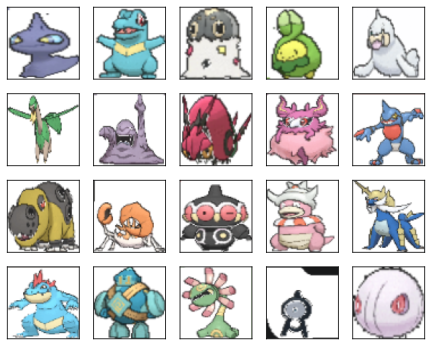

In [14]:

d2l.set_figsize(figsize=(4, 4))
for X, y in data_iter.take(1):
    imgs = X[:20, :, :, :] / 2 + 0.5
    d2l.show_images(imgs, num_rows=4, num_cols=5)

#c- Creating the generator

The generator needs to map the noise variable to a RGB image with width and height to be $64\times 64$ .

In [15]:
## The Generator

class G_block(tf.keras.layers.Layer):
    def __init__(self, out_channels, kernel_size=4, strides=2, padding="same",
                 **kwargs):
        super().__init__(**kwargs)
        self.conv2d_trans = tf.keras.layers.Conv2DTranspose(
            out_channels, kernel_size, strides, padding, use_bias=False)
        self.batch_norm = tf.keras.layers.BatchNormalization()
        self.activation = tf.keras.layers.ReLU()

    def call(self, X):
        return self.activation(self.batch_norm(self.conv2d_trans(X)))

# Explain your understanding of the G_block here.

The `G_block` class is a custom layer in TensorFlow that performs a specific set of operations on the input, specitically it transforms the input data through a series of processes that include:

- A 2D convolutional transpose operation (also known as deconvolution) that upsamples the incoming feature maps, increasing their width and height dimensions, while transforming the number of channels to a specified amount.
- A batch normalization operation that standardizes the outputs from the previous layer, helping in stabilizing and accelerating model's training.
- An activation function (ReLU) that introduces non-linearity into the model, allowing it to learn more complex patterns.

In [16]:
x = tf.zeros((2, 16, 16, 3))  # Input based on the instruction
#Call the G_block package and use 20 as the number of layers (input of the class)
g_blk = G_block(20)
# Show the dimension of the output
g_blk(x).shape

TensorShape([2, 32, 32, 20])

### Explain your understanding from this model here?

The G_block class in the code is a generator block used in Generative Adversarial Networks (GANs). Its role is to generate synthetic data from random noise. It employs a Conv2DTranspose layer for upscaling input, BatchNormalization for stabilizing learning process, and ReLU activation function to introduce non-linearity.

In [17]:
n_G = 64
net_G = tf.keras.Sequential([
    # Output: (4, 4, 64 * 8)
    G_block(out_channels=n_G*8, strides=1, padding="valid"),
    G_block(out_channels=n_G*4), # Output: (8, 8, 64 * 4)
    G_block(out_channels=n_G*2), # Output: (16, 16, 64 * 2)
    G_block(out_channels=n_G), # Output: (32, 32, 64)
    # Output: (64, 64, 3)
    tf.keras.layers.Conv2DTranspose(
        3, kernel_size=4, strides=2, padding="same", use_bias=False,
        activation="tanh")
])

The G_block class in the code is a generator block used in Generative Adversarial Networks (GANs). Its role is to generate synthetic data from random noise. It employs a Conv2DTranspose layer for upscaling input, BatchNormalization for stabilizing learning process, and ReLU activation function to introduce non-linearity.

In [18]:
# Generate a 100 dimensional latent variable to verify the generator's output shape.
x = tf.zeros((1, 1, 1, 100))
net_G(x).shape

TensorShape([1, 64, 64, 3])

## Discriminator

The discriminator is a normal convolutional network network except that it uses a leaky ReLU as its activation function. Given $\alpha \in[0, 1]$, its definition is

$$\textrm{leaky ReLU}(x) = \begin{cases}x & \text{if}\ x > 0\\ \alpha x &\text{otherwise}\end{cases}.$$

As it can be seen, it is normal ReLU if $\alpha=0$, and an identity function if $\alpha=1$. For $\alpha \in (0, 1)$, leaky ReLU is a nonlinear function that give a non-zero output for a negative input. It aims to fix the "dying ReLU" problem that a neuron might always output a negative value and therefore cannot make any progress since the gradient of ReLU is 0.

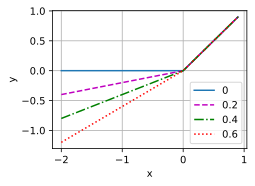

In [19]:
alphas = [0, .2, .4, .6, .8, 1]
x = tf.range(-2, 1, 0.1)
Y = [tf.keras.layers.LeakyReLU(alpha)(x).numpy() for alpha in alphas]
d2l.plot(x.numpy(), Y, 'x', 'y', alphas)

The basic block of the discriminator is a convolution layer followed by a batch normalization layer and a leaky ReLU activation. The hyperparameters of the convolution layer are similar to the transpose convolution layer in the generator block

## d- Block of Discriminator

In [20]:

class D_block(tf.keras.layers.Layer):
    def __init__(self, out_channels, kernel_size=4, strides=2, padding="same",
                 alpha=0.2, **kwargs):
        super().__init__(**kwargs)
        self.conv2d = tf.keras.layers.Conv2D(out_channels, kernel_size,
                                             strides, padding, use_bias=False)
        self.batch_norm = tf.keras.layers.BatchNormalization()
        self.activation = tf.keras.layers.LeakyReLU(alpha)

    def call(self, X):
        return self.activation(self.batch_norm(self.conv2d(X)))

In [21]:
x = tf.zeros((2, 16, 16, 3))
#Call the G_block package and use 20 as the number of layers (input of the class)
d_blk = D_block(20)
# Show the dimension of the output
d_blk(x).shape


TensorShape([2, 8, 8, 20])

The discriminator is a mirror of the generator.


In [22]:
n_D = 64
net_D = tf.keras.Sequential([
    D_block(n_D), # Output: (32, 32, 64)
    D_block(out_channels=n_D*2), # Output: (16, 16, 64 * 2)
    D_block(out_channels=n_D*4), # Output: (8, 8, 64 * 4)
    D_block(out_channels=n_D*8), # Outupt: (4, 4, 64 * 64)
    # Output: (1, 1, 1)
    tf.keras.layers.Conv2D(1, kernel_size=4, use_bias=False)
])

In [23]:
#It uses a convolution layer with output channel  1  as the last layer to obtain a single prediction value.
x = tf.zeros((1, 64, 64, 3))
net_D(x).shape

TensorShape([1, 1, 1, 1])

## Training

In [24]:
def train(net_D, net_G, data_iter, num_epochs, lr, latent_dim,
          device=d2l.try_gpu()):
    loss = tf.keras.losses.BinaryCrossentropy(
        from_logits=True, reduction=tf.keras.losses.Reduction.SUM)

    for w in net_D.trainable_variables:
        w.assign(tf.random.normal(mean=0, stddev=0.02, shape=w.shape))
    for w in net_G.trainable_variables:
        w.assign(tf.random.normal(mean=0, stddev=0.02, shape=w.shape))

    optimizer_hp = {"lr": lr, "beta_1": 0.5, "beta_2": 0.999}
    optimizer_D = tf.keras.optimizers.Adam(**optimizer_hp)
    optimizer_G = tf.keras.optimizers.Adam(**optimizer_hp)

    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[1, num_epochs], nrows=2, figsize=(5, 5),
                            legend=['discriminator', 'generator'])
    animator.fig.subplots_adjust(hspace=0.3)

    for epoch in range(1, num_epochs + 1):
        # Train one epoch
        timer = d2l.Timer()
        metric = d2l.Accumulator(3) # loss_D, loss_G, num_examples
        for X, _ in data_iter:
            batch_size = X.shape[0]
            Z = tf.random.normal(mean=0, stddev=1,
                                 shape=(batch_size, 1, 1, latent_dim))
            metric.add(d2l.update_D(X, Z, net_D, net_G, loss, optimizer_D),
                       d2l.update_G(Z, net_D, net_G, loss, optimizer_G),
                       batch_size)

        # Show generated examples
        Z = tf.random.normal(mean=0, stddev=1, shape=(21, 1, 1, latent_dim))
        # Normalize the synthetic data to N(0, 1)
        fake_x = net_G(Z) / 2 + 0.5
        imgs = tf.concat([tf.concat([fake_x[i * 7 + j] for j in range(7)],
                                    axis=1)
                          for i in range(len(fake_x) // 7)], axis=0)
        animator.axes[1].cla()
        animator.axes[1].imshow(imgs)
        # Show the losses
        loss_D, loss_G = metric[0] / metric[2], metric[1] / metric[2]
        animator.add(epoch, (loss_D, loss_G))
    print(f'loss_D {loss_D:.3f}, loss_G {loss_G:.3f}, '
          f'{metric[2] / timer.stop():.1f} examples/sec on {str(device._device_name)}')

### Explain your understanding from this model here?

The Discriminator in this code does the following:

- It functions as a binary classification model, distinguishing between real and generated images.
- Utilizes Convolutional layers to extract features from input images, which helps identify patterns and structures.
- The LeakyReLU activation function allows small negative values when the input is less than zero, mitigating the "dying ReLU" problem where some neurons become inactive and only output 0's.
- The gradual increase in the number of channels helps to capture more complex patterns at each layer.
- Lastly, Conv2D layer with output channel 1 is used to obtain a single prediction value indicating whether the input image is real or fake.


loss_D 0.068, loss_G 6.555, 493.3 examples/sec on /GPU:0


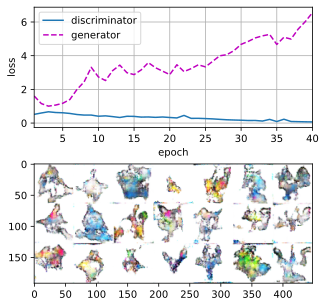

In [25]:
#We train the model with a small number of epochs just for demonstration. For better performance, the variable num_epochs can be set to a larger number.
latent_dim, lr, num_epochs = 100, 0.0005, 40
train(net_D, net_G, data_iter, num_epochs, lr, latent_dim)

In [ ]:
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc

In [42]:
!mount -a

In [45]:
!ls /content/

sample_data
